In [1]:
import os
import csv
from typing import Any, Tuple, List

from PIL import Image

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random 
import glob
import cv2

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


In [3]:
df: pd.DataFrame = pd.read_csv('Annotasion2.csv', usecols=["Absolute path", "Class name"])
df: pd.DataFrame = df.rename(columns={'Absolute path': 'absPath',
               'Class name': 'className'})
train_size = int(0.8 * df.shape[0])
test_valid_size = int(0.1*df.shape[0])
df_training = df.iloc[:train_size, :]
df_test = df.iloc[train_size:train_size + test_valid_size, :]
df_validation = df.iloc[train_size + test_valid_size:, :]

print('train', df_training)
print('valid', df_validation)
print('test', df_test)


train                                   absPath className
0     C:\pp var 4\dataset2\tulip_0000.jpg     tulip
1     C:\pp var 4\dataset2\tulip_0001.jpg     tulip
2     C:\pp var 4\dataset2\tulip_0002.jpg     tulip
3     C:\pp var 4\dataset2\tulip_0003.jpg     tulip
4     C:\pp var 4\dataset2\tulip_0004.jpg     tulip
...                                   ...       ...
1595   C:\pp var 4\dataset2\rose_0595.jpg      rose
1596   C:\pp var 4\dataset2\rose_0596.jpg      rose
1597   C:\pp var 4\dataset2\rose_0597.jpg      rose
1598   C:\pp var 4\dataset2\rose_0598.jpg      rose
1599   C:\pp var 4\dataset2\rose_0599.jpg      rose

[1600 rows x 2 columns]
valid                                  absPath className
1800  C:\pp var 4\dataset2\rose_0800.jpg      rose
1801  C:\pp var 4\dataset2\rose_0801.jpg      rose
1802  C:\pp var 4\dataset2\rose_0802.jpg      rose
1803  C:\pp var 4\dataset2\rose_0803.jpg      rose
1804  C:\pp var 4\dataset2\rose_0804.jpg      rose
...                              

In [4]:
class MyDataset(Dataset):
    def __init__(self, path_to_annot_file: str, transform: Any=None, train: bool=False, test: bool=False, valid: bool=False) -> None:
        self.path_to_annot_file = path_to_annot_file
        self.data = self.get_data(path_to_annot_file, train, test, valid)
        self.transform = transform

    def get_data(self, path_to_annot_file: str, train: bool=False, test: bool=False, valid: bool=False) -> pd.DataFrame:
        data: pd.DataFrame = pd.read_csv('Annotasion2.csv', usecols=["Absolute path", "Class name"])
        data: pd.DataFrame = data.rename(columns={'Absolute path': 'absPath',
               'Class name': 'className'})
        data = data.sample(frac=1).reset_index(drop=True)
        data['className'] = data['className'].apply(lambda label: 0 if label == 'rose' else 1)
        
        train_size = int(0.8 * data.shape[0])
        test_valid_size = int(0.1 * data.shape[0])
        if train == True:
            data = data.iloc[:train_size, :]
        elif test == True:
            data = data.iloc[train_size:train_size + test_valid_size, :]
        elif valid == True:
            data = data.iloc[train_size + test_valid_size:, :]
        return data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        path_to_image = self.data.iloc[index, 0]
        image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
        label = self.data.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                    torchvision.transforms.RandomHorizontalFlip(p=0.3)])

In [6]:
train_data = MyDataset(path_to_annot_file='C:/pp var 4/fifth/Annotasion2.csv', transform=transforms , train = True)
test_data = MyDataset(path_to_annot_file='C:/pp var 4/fifth/Annotasion2.csv', transform=transforms , test = True)
valid_data = MyDataset(path_to_annot_file='C:/pp var 4/fifth/Annotasion2.csv', transform=transforms , valid = True)
batch_size = 4
len(train_data), len(test_data), len(valid_data)

(1600, 200, 200)

In [7]:
print(train_data[0])

(tensor([[[ 0.3481,  0.4569,  0.5352,  ..., -0.1828, -0.1314, -0.1314],
         [ 0.3652,  0.4569,  0.5352,  ..., -0.1486, -0.1314, -0.1143],
         [ 0.3786,  0.4193,  0.5352,  ..., -0.0972, -0.1143, -0.1106],
         ...,
         [ 1.6566,  0.3272,  0.2555,  ..., -1.4635, -1.2461, -1.5012],
         [ 0.3348,  0.3686,  0.0709,  ..., -1.4112, -1.2926, -1.5454],
         [ 0.5802,  0.2823,  0.2995,  ..., -1.3604, -1.5070, -1.5454]],

        [[ 0.3277,  0.4390,  0.5191,  ...,  0.1352,  0.1352,  0.1352],
         [ 0.3452,  0.4390,  0.5191,  ...,  0.1176,  0.1352,  0.1527],
         [ 0.3590,  0.4006,  0.5191,  ...,  0.1352,  0.1527,  0.1564],
         ...,
         [ 0.3784, -1.0288, -0.9119,  ..., -1.3750, -0.9500, -1.3025],
         [-0.8596, -1.2002, -0.9735,  ..., -1.1869, -0.9678, -1.3392],
         [-0.3591, -0.9461, -0.7398,  ..., -1.1213, -1.1486, -1.3392]],

        [[ 0.4614,  0.5722,  0.6518,  ...,  0.7054,  0.6879,  0.6879],
         [ 0.4788,  0.5722,  0.6518,  ...,  

c:\Users\toral\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [8]:
train_data.data['className'].value_counts()

className
1    803
0    797
Name: count, dtype: int64

In [9]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.max_pool = nn.MaxPool2d(2)

        self.fully_connect1 = nn.Linear(5408, 10)
        self.fully_connect2 = nn.Linear(10, 1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = torch.flatten(output, start_dim=1)
        output = self.relu(self.fully_connect1(output))
        output = torch.sigmoid(self.fully_connect2(output))
        return output

In [10]:
model = CNN().to(device)
model.train()

CNN(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fully_connect1): Linear(in_features=5408, out_features=10, bias=True)
  (fully_connect2): Linear(in_features=10, out_features=1, bias=True)
)

In [11]:
train_loader = DataLoader(dataset = train_data, batch_size=16, shuffle=True )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([16, 3, 224, 224])


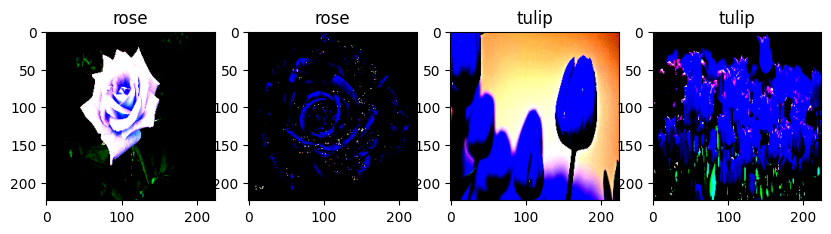

In [12]:
plt.figure(figsize=(10, 5))

for i_batch, sample_batched in enumerate(train_loader):
    if i_batch == 1:
      break

    print(i_batch, sample_batched[0].shape)

    for j in range(4):
      plt.subplot(1, 4, j + 1)
      plt.title("rose" if sample_batched[1][j] == 0 else "tulip")
      plt.imshow(sample_batched[0][j].permute(1, 2, 0).numpy()[:, :, ::-1])

In [13]:
parameters = {'lr': [0.01],
              'batch_size' : [32]}

In [14]:
for lr in parameters['lr']:
    for bs in parameters['batch_size']:
        optimizer = optim.Adam(params=model.parameters(), lr=lr)
        criterion = nn.BCELoss(reduction='sum')

        train_loader = DataLoader(dataset=train_data, batch_size=bs, shuffle = True)
        test_loader = DataLoader(dataset=test_data, batch_size=bs, shuffle = False)
        valid_loader = DataLoader(dataset=valid_data, batch_size=bs, shuffle = False)

        epochs = 12

        train_accuracy_values = []
        train_loss_values = []

        val_accuracy_values = []
        val_loss_values = []

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}")
            model.train()
            epoch_loss = 0
            epoch_accuracy = 0

            epoch_val_loss = 0
            epoch_val_accuracy = 0

            for data, className in train_loader:
                data = data.to(device)
                className = className.to(device)

                output = model(data)
                loss = criterion(output, className.unsqueeze(dim=1).to(torch.float))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(className[j]) else 0 for j in range(len(className))])).sum()

                epoch_accuracy += acc / len(train_data)
                epoch_loss += loss / len(train_data)

            model.eval()
            for data, className in valid_loader:
                data = data.to(device)
                className = className.to(device)

                output = model(data)
                loss = criterion(output, className.unsqueeze(dim=1).to(torch.float))
                acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(className[j]) else 0 for j in range(len(className))])).sum()

                epoch_val_accuracy += acc / len(valid_data)
                epoch_val_loss += loss / len(valid_data)

            val_accuracy_values.append(epoch_val_accuracy)
            val_loss_values.append(epoch_val_loss)

            train_accuracy_values.append(epoch_accuracy)
            train_loss_values.append(epoch_loss)

            print(f"Epoch {epoch + 1} end")

            print('Epoch: {}, train_accuracy: {}, train_loss: {}'.format(epoch + 1, epoch_accuracy, epoch_loss))
            print('Epoch: {}, valid_accuracy: {}, valid_loss: {}'.format(epoch + 1, epoch_val_accuracy, epoch_val_loss))

        train_loss_values = [value.cpu().detach().numpy() for value in train_loss_values]
        val_loss_values = [value.cpu().detach().numpy() for value in val_loss_values]

        plt.figure(figsize=(12,10))

        plt.subplot(2, 1, 1)
        plt.title(f"Train. Batch Size = {bs}, Learning Rate = {lr}")
        plt.plot(range(1, epochs + 1), train_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), train_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])
        plt.subplot(2, 1, 2)
        plt.title(f"Valid. Batch Size = {bs}, Learning Rate = {lr}")
        plt.plot(range(1, epochs + 1), val_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), val_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])

        #model.eval()
        test_loss = 0
        test_accuracy = 0
        for data, className in test_loader:
            data = data.to(device)
            className = className.to(device)

            output = model(data)
            loss = criterion(output, className.unsqueeze(dim=1).to(torch.float))

            acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(className[j]) else 0 for j in range(len(className))])).sum()

            test_accuracy+=acc / len(test_data)
            test_loss+=loss / len(test_data)

        torch.save(model.state_dict(), os.path.join('C://pp var 4//fifth', f"bs{bs}_lr{lr}_weight.pth"))

        print('LR: {}, BS: {}, test_accuracy: {}, test_loss: {}'.format(lr, bs, test_accuracy, test_loss))

Epoch 1
Epoch 1 end
Epoch: 1, train_accuracy: 0.5200000000000001, train_loss: 0.7207722067832947
Epoch: 1, valid_accuracy: 0.645, valid_loss: 0.6856107711791992
Epoch 2
Epoch 2 end
Epoch: 2, train_accuracy: 0.6587500000000003, train_loss: 0.6342455744743347
Epoch: 2, valid_accuracy: 0.72, valid_loss: 0.5779519081115723
Epoch 3
Epoch 3 end
Epoch: 3, train_accuracy: 0.7037500000000001, train_loss: 0.5672752857208252
Epoch: 3, valid_accuracy: 0.75, valid_loss: 0.5507910251617432
Epoch 4
Epoch 4 end
Epoch: 4, train_accuracy: 0.7281250000000001, train_loss: 0.5442039370536804
Epoch: 4, valid_accuracy: 0.76, valid_loss: 0.5119199156761169
Epoch 5
Epoch 5 end
Epoch: 5, train_accuracy: 0.763125, train_loss: 0.5113393068313599
Epoch: 5, valid_accuracy: 0.7450000000000001, valid_loss: 0.5128796696662903
Epoch 6
Epoch 6 end
Epoch: 6, train_accuracy: 0.7712500000000001, train_loss: 0.4999092221260071
Epoch: 6, valid_accuracy: 0.78, valid_loss: 0.488197922706604
Epoch 7
Epoch 7 end
Epoch: 7, train_

: 

In [ ]:
plt.figure(figsize=(10, 5))

for j in range(5):
  index = random.randint(0, 199)
  plt.subplot(1, 5, j + 1)
  plt.title("Rose" if (1 if  model(test_data[index][0].unsqueeze(dim=0).to(device))[0] >= 0.5 else 0) == 0 else "Tulip")
  plt.imshow(test_data[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])

NameError: name 'plt' is not defined